# 线性回归的从零开始实现

我们将从零开始实现整个方法，
包括数据流水线、模型、损失函数和小批量随机梯度下降优化器

In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

根据带有噪声的线性模型构造一个人造数据集。
我们使用线性模型参数$\mathbf{w} = [2, -3.4]^\top$、$b = 4.2$
和噪声项$\epsilon$生成数据集及其标签：

$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon$$

In [10]:
# 生成数据集

def synthetic_data(w, b, num_examples):  
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))  # 生成特征X (1000,2) ,每一行是一个样本
    print(X.shape)  # 1000 * 2
    print(w)        # 1 * 2 
    # 具体计算过程见md
    y = torch.matmul(X, w) + b                      # 生成标签y (1000,1)，每一行是一个样本的标签
    print(y.shape)  # 1000 * 1 
    y += torch.normal(0, 0.01, y.shape)             # 加上噪声
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])  # 设定的真实权重
true_b = 4.2                      # 设定的真实偏差
features, labels = synthetic_data(true_w, true_b, 1000)
print('features:', features[:10],'\nlabel:', labels[:10])

torch.Size([1000, 2])
tensor([ 2.0000, -3.4000])
torch.Size([1000])
features: tensor([[ 0.1896,  1.3179],
        [-1.5810, -0.0369],
        [ 0.7992,  1.1489],
        [-0.3062,  0.1575],
        [-1.3239, -0.8722],
        [ 0.3366, -0.9049],
        [-0.1544, -0.9401],
        [ 0.1517,  1.2235],
        [ 2.4094,  0.9798],
        [-2.4906,  0.6118]]) 
label: tensor([[ 0.1037],
        [ 1.1652],
        [ 1.9025],
        [ 3.0587],
        [ 4.5082],
        [ 7.9513],
        [ 7.0793],
        [ 0.3293],
        [ 5.6961],
        [-2.8525]])


`features`中的每一行都包含一个二维数据样本，
`labels`中的每一行都包含一维标签值（一个标量）

In [4]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([-0.3679, -1.8471]) 
label: tensor([9.7361])


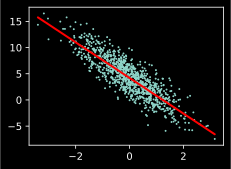

In [20]:
d2l.set_figsize()
# 生成散点图
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1)
# 画出真实的线
d2l.plt.plot(features[:, 1].detach().numpy(), (true_w[1] * features[:, 1] + true_b).detach().numpy(), '-r', lw=2)

定义一个`data_iter`函数，
该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为`batch_size`的小批量

In [25]:
def data_iter(batch_size, features, labels):
    num_examples = len(features) # 样本的个数
    indices = list(range(num_examples))
    random.shuffle(indices) # 样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size): # 每次读取batch_size个样本
        # indices 是一个长度为num_examples的list，里面的每个元素是样本的索引
        # i是从0开始到num_examples，步长为batch_size
        # batch_indices是取出来的样本的索引
        # 最后一个batch可能不足一个batch_size
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)]) 
        # yield就是 return 返回一个值，并且记住这个返回的位置，下次迭代就从这个位置后开始。
        yield features[batch_indices], labels[batch_indices]

batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 1.3443,  0.5554],
        [ 0.0367, -1.7613],
        [ 1.1427, -2.0695],
        [-3.3416,  0.6860],
        [ 0.4489,  1.1933],
        [-0.2106, -0.3143],
        [ 2.6082,  0.8280],
        [ 1.1524,  1.0136],
        [ 0.5963,  0.1678],
        [-1.7063,  0.0478]]) 
 tensor([[ 5.0121],
        [10.2440],
        [13.5131],
        [-4.8078],
        [ 1.0565],
        [ 4.8352],
        [ 6.6163],
        [ 3.0670],
        [ 4.8307],
        [ 0.6264]])


在我们开始用小批量随机梯度下降优化我们的模型参数之前
我们需要先有一些参数

In [8]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

定义模型，将模型的输入和参数同模型的输出关联起来

In [9]:
def linreg(X, w, b):  
    """线性回归模型"""
    return torch.matmul(X, w) + b

定义损失函数

In [10]:
def squared_loss(y_hat, y):  
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

定义优化算法

In [11]:
def sgd(params, lr, batch_size):  
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

训练过程

In [13]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.043705
epoch 2, loss 0.000172
epoch 3, loss 0.000047


比较真实参数和通过训练学到的参数来评估训练的成功程度

In [14]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 0.0003, -0.0002], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0010], grad_fn=<RsubBackward1>)
